In [1]:
# !pip install -c pip -forge xgboost=1.3.3
# !pip install -c pip -forge lightgbm=3.1.1 
# !pip install -c pip -forge missingno=0.4.2

## 1. 필요한 라이브러리 import 하기

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

## 2. 데이터살펴보기

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/Github/AIFFEL/E06/data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Github/AIFFEL/E06/data/test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print("train.csv. Shape: ",df_train.shape)
print("test.csv. Shape: ",df_test.shape)

FileNotFoundError: ignored

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

## 3. 데이터불러오기

In [ ]:
df_train.head()

In [ ]:
df_train['price'].describe()

## 4. 데이터 전처리

In [ ]:
#결측치 확인
msno.matrix(df_train)

In [ ]:
# 직접 채워줘야 하는 데이터들
df_train.isnull().sum()

-> 결측치가 없군요!

In [ ]:
#상관관계 분석
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

price와 상관관계 높은 네 가지 feature

- 'grade': King County grading 시스템 기준으로 매긴 집의 등급
- 'sqft_living':주거 공간의 평방 피트
- 'sqft_living15':2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
- sqft_above : 지하실을 제외한 평방 피트

-> 집 가격은 등급과 집의 크기와 관련이 있구나!

In [ ]:
#train: id, date 변수 정리
# sub_id = df_train['id'][train_len:]
# del df_train['id']
df_train['date'] = df_train['date'].apply(lambda x : str(x[:6])).astype(str)
df_train.head()

In [ ]:
#test: id, date 변수 정리
# sub_id = df_test['id'][train_len:]
# del df_test['id']
df_test['date'] = df_test['date'].apply(lambda x : str(x[:6])).astype(str)
df_test.head()

In [ ]:
# price 칼럼은 따로 빼준다.
y = df_train['price']
del df_train['price']
print(df_train.columns)

In [ ]:
# id 컬럼까지 삭제
del df_train['id']

print(df_train.columns)

In [ ]:
# test 데이터에서도 id 칼럼 삭제
df_test['date'] = df_test['date'].apply(lambda i: i[:6]).astype(int)

del df_test['id']

print(df_test.columns)

In [ ]:
df_test.head()

In [ ]:
#타겟데이터
y

In [ ]:
#가격의 분포
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y)

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Kurtosis 값이 3에 가까울 수록 정규분포를 따르는데, 값이 40인 것으로 봐서 정규화가 필요한 것으로 판단된다.

-> log 를 취하여 정규화하자!

In [ ]:
y = np.log1p(y)
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y)

-> 정규화 완료!

In [ ]:
#grade
data = pd.concat([y, df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

- 이건 어떻게 보고 전처리 해야할까

In [ ]:
#sqft_living
data = pd.concat([y, df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

- price와 sqft_living는 양의 상관관계를 가지는데, 지나치게 튀는 값이 없는 지 확인하기 위해 그래프를 그렸다.



In [ ]:
#sqft_living - outlier 제거
# search_df = df_train.loc[df_train['sqft_living'] > 13000] 
# df_train = df_train.drop(search_df.index, axis=0)
# y = y.drop(search_df.index, axis=0)
df_train.loc[df_train['sqft_living'] > 13000] 

- 12000 뒤에 있는게 다른 데이터들의 흐름에 벗어나므로 데이터 학습에 방해가 될 수 있으니 제거하는 것이 좋겠다.

In [ ]:
#sqft_above
data = pd.concat([y, df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_above', y="price", data=data)

- 이건 괜찮은 듯

In [ ]:
data = pd.concat([y, df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

- 이것도 무난한 듯

In [ ]:
#특정 feature 정규화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [ ]:
df_train.head()

In [ ]:
del df_train["date"]
del df_test["date"]

In [ ]:
#새로운 피처 추가 생성 (시간이 된다면)

In [ ]:
df_train.info()

## 5. 모델링

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [ ]:
gboost.__class__.__name__ #모델의 이름 얻기

In [ ]:
df = {}

for model in models:
    
    model_name = model.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(df_train, y, random_state=random_state, test_size=0.2)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    df[model_name] = rmse(y_test, y_pred)
    
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [ ]:
from sklearn.model_selection import GridSearchCV

우선 그리드 탐색과 랜덤 탐색을 알아볼 필요가 있습니다. 두 가지 모두 하이퍼 파라미터를 조합해 보는 방법입니다.

그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리


랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법입니다.

param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)

scoring : 모델의 성능을 평가할 지표

cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수

verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)

n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}#가능한 조합은 총 2x2 = 4가지 
#cross validation은 경우마다 5번 진행 -> 4x5 = 20 fits진행

In [ ]:
model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(df_train, y)

In [ ]:
grid_model.cv_results_ #grid_model.fit 함수를 통해서 4가지 조합에 대한 실험 결과

In [ ]:
params = grid_model.cv_results_['params']
params

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results
#왜 스코어값이 음수? 
#GridSearchCV에서 모델을 초기화할 때 scoring 인자에 MSE에 음수를 취한 값인 neg_mean_squared_error가 들어감

In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])#음수로 된 MSE였으니, -1을 곱해주고 np.sqrt로 루트 연산
results

In [ ]:
results = results.rename(columns={'RMSE': 'RMSLE'})#사실상 Root Mean Squared Log Error임
results

In [ ]:
results = results.sort_values('RMSLE')
results

In [ ]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, df_train, y, param_grid, verbose=2, n_jobs=5)

In [ ]:
model = LGBMRegressor(max_depth=25, n_estimators=300, random_state=random_state)
model.fit(df_train, y)
prediction = model.predict(df_test)
prediction

In [ ]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/drive/MyDrive/Github/AIFFEL/E06/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, df_train, y, df_test, 'lgbm', rmsle='0.271886')

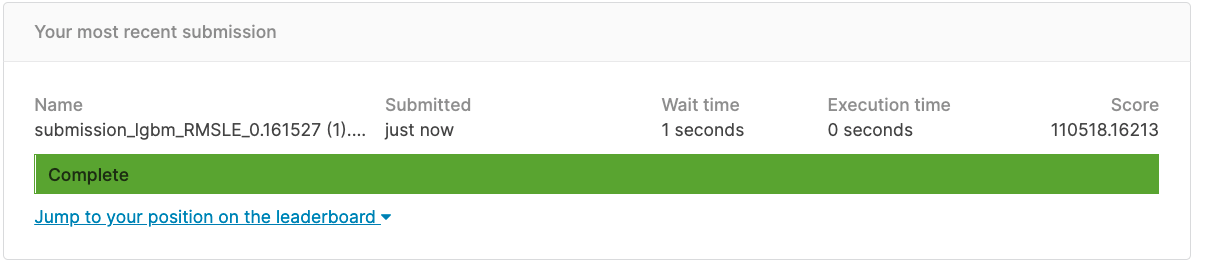